# Time Series Classification Algorithms - (2) Dictionary Based

<div style="border: 1px solid #007acc; background-color: #e6f4ff; padding: 10px; border-radius: 5px; color: black;">
  <strong>📘 Info:</strong> I do not claim ownership of the content in this notebook. It is based on official <a href="https://www.aeon-toolkit.org/en/latest/examples.html" target="_blank">aeon tutorials</a>, and parts of the code or text may have been copy-pasted or adapted directly from those or other sources for learning purposes.
</div>

In [1]:
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

In [ ]:
import matplotlib.pyplot as plt

import pandas as pd

import seaborn as sns

from sklearn import metrics

import time

In [3]:
from aeon.datasets import load_classification
from aeon.utils.discovery import all_estimators

# all_estimators("classifier", tag_filter={"algorithm_type": "dictionary"})

In [4]:
from aeon.classification.dictionary_based import (
    BOSSEnsemble,
    MUSE,
    TemporalDictionaryEnsemble,
    WEASEL
)

In [5]:
from pyts.bag_of_words import BagOfWords
from pyts.classification import SAXVSM

In [6]:
DATASET_NAMES = [
    "MelbournePedestrian",
    "ArrowHead",
    "Colposcopy"
]

X_train_dict, y_train_dict = {}, {}
X_test_dict, y_test_dict = {}, {}

accuracy_dict, f1_score_dict, duration_dict = {}, {}, {}

for dataset_name in DATASET_NAMES: 
    X_train_dict[dataset_name], y_train_dict[dataset_name] = load_classification(
        dataset_name, split="train"
    )
    X_test_dict[dataset_name], y_test_dict[dataset_name] = load_classification(
        dataset_name, split="test"
    )

    X_train_dict[dataset_name] = X_train_dict[dataset_name].squeeze(1)
    X_test_dict[dataset_name] = X_test_dict[dataset_name].squeeze(1)

    accuracy_dict[dataset_name] = {}
    f1_score_dict[dataset_name] = {}
    duration_dict[dataset_name] = {}

```bibtex
@inbook{faouzi2024,
  author = {Johann Faouzi},
  title = {Time Series Classification: A Review of Algorithms and Implementations},
  year = {2024},
  month = {March},
  booktitle = {Advances in Time Series Analysis and Forecasting},
  publisher = {IntechOpen},
  isbn = {978-0-85466-053-7},
  doi = {10.5772/intechopen.1004810},
}
```

"Bag-of-words approaches, also known as dictionary-based approaches, consists in discretizing time series into sequences of symbols, then extracting words from these sequences with a sliding window, and finally counting the number of words for all the words in the dictionary. These approaches are split into two groups: the ones based on discretizing raw time series, and the other ones based on discretizing Fourier coefficients. \cite{faouzi2024}"

## 1. Symbolic Aggregation approXimation (SAX)

"The most commonly used algorithm to discretize raw time series is called Symbolic Aggregation approXimation (SAX) and simply maps each real-valued observation of the time series to its corresponding bin. Several strategies to compute the bin edges are possible: quantiles of the standard normal distribution if the time series was standardized (zero mean, unit variance), uniform bins based on the extreme values of the time series, or quantiles of the time series. Based on the SAX discretization of standardized time series with quantiles of the standard normal distribution, the bag-of-patterns algorithm uses a sliding window to extract words from the discretized time series and computes the corresponding histogram; that, is the frequency of each word is computed, resulting in a new data set in which each feature is a word from the dictionary and each value is the number of occurrences of the given word in a given time series. Since consecutive subsequences are likely to be very similar and thus lead to identical words, it was proposed to count a single occurrence of identical consecutive words, this process being called numerosity reduction. Finally, a nearest-neighbor classifier was built on top of this transformation to perform classification." \cite{faouzi2024}

<img src="images/02_sax.png" style="width:600px; border: 1px solid #ccc; border-radius: 5px;">

In [7]:
WINDOWS_SIZE, WORD_SIZE = 15, 15
bow = BagOfWords(
    window_size=WINDOWS_SIZE, word_size=WORD_SIZE,
    window_step=WINDOWS_SIZE, numerosity_reduction=False,
    strategy='uniform'
)
X_train_bow = bow.transform(X_train_dict["MelbournePedestrian"])
X_test_bow = bow.transform(X_test_dict["MelbournePedestrian"])

In [8]:
X_train_bow

array(['aaaaaaaabbbcddc', 'aaaaaaaaaabcddd', 'aaaaaaaaaabcddd', ...,
       'bbaaaaaaabcdddd', 'aaaaaaabccccddd', 'aaaaaaabdcbbddc'],
      dtype='<U15')

In [9]:
X_test_bow

array(['aaaaaaaaaabbddd', 'aaaaaaaaabbcddc', 'aaaaaaaaabbcddd', ...,
       'aaaaaaabdcbbddc', 'baaaaaaaabbcddd', 'aaaaaaabdbbcddc'],
      dtype='<U15')

### 1.1. Symbolic Aggregation approXimation in Vector Space Model (SAX-VSM)

```bibtex
@inproceedings{senin2013,
  author = {Senin, Pavel and Malinchik, Sergey},
  booktitle = {2013 IEEE 13th International Conference on Data Mining}, 
  title = {SAX-VSM: Interpretable Time Series Classification Using SAX and Vector Space Model}, 
  year = {2013},
  pages = {1175--1180},
  doi = {10.1109/ICDM.2013.52}
}
```

Proposed by \cite{senin2013}.

"Another algorithm, called Symbolic Aggregation approXimation in Vector Space Model (SAX-VSM), was later proposed with two major differences from the bag-of-patterns algorithm. First, the order of the preprocessing steps is changed. The sliding window is applied to the raw time series to extract subsequences. Each subsequence is standardized and discretized using the SAX algorithm, resulting in an ordered sequence of words, to which numerosity reduction is usually applied. Second, classification is based on a simple numerical statistic used in natural language processing: the term frequency—inverse document frequency (TF-IDF) matrix. The idea is to identify words that are specific to each class. After computing the frequency of each word in the dictionary for each time series (resulting in a vector for each time series), all the vectors corresponding to time series belonging to the same class are summed in order to obtain the frequency of each word for each class. This process results in the term frequency matrix, whose rows represent the words in the dictionary, the columns represent the classes in the data set, and each entry is the frequency of the given word for the given class. Each row of this matrix is then normalized by the number of classes in which the word is present so that words that are specific to a small number of classes are more heavily weighted than words present in many classes. This normalized matrix is the so-called TF-IDF matrix. Classification is performed using the cosine similarity between the word frequency vector of a new time series and each column of the TD-IDF matrix, the predicted class being the one yielding the highest cosine similarity." \cite{faouzi2024}

In [10]:
method = "SAX-VSM"
print(method)

for dataset_name in DATASET_NAMES:
    start_time = time.time()

    sax_vsm = SAXVSM(
        window_size=WINDOWS_SIZE, word_size=WORD_SIZE,
        window_step=WINDOWS_SIZE, numerosity_reduction=False,
        strategy='uniform'
    )
    sax_vsm.fit(X_train_dict[dataset_name], y_train_dict[dataset_name])
    sax_vsm_preds = sax_vsm.predict(X_test_dict[dataset_name])
    accuracy_dict[dataset_name][method] = metrics.accuracy_score(
        y_test_dict[dataset_name], sax_vsm_preds
    )
    f1_score_dict[dataset_name][method] = metrics.f1_score(
        y_test_dict[dataset_name], sax_vsm_preds,
        average="weighted"
    )

    elapsed_time = time.time() - start_time
    duration_dict[dataset_name][method] = elapsed_time
    print("-------------------------------------------")
    print(f"Dataset: {dataset_name}")
    print(f"Accuracy: {accuracy_dict[dataset_name][method]:.2f}")
    print(f"F1-Score: {f1_score_dict[dataset_name][method]:.2f}")
    print(f"Duration: {duration_dict[dataset_name][method]:.2f} seconds")

SAX-VSM
-------------------------------------------
Dataset: MelbournePedestrian
Accuracy: 0.61
F1-Score: 0.62
Duration: 0.03 seconds
-------------------------------------------
Dataset: ArrowHead
Accuracy: 0.37
F1-Score: 0.35
Duration: 0.20 seconds
-------------------------------------------
Dataset: Colposcopy
Accuracy: 0.08
F1-Score: 0.01
Duration: 0.01 seconds


## 2. Bag-of-SFA-Symbols (BOSS)

```bibtex
@article{schafer2015,
  author = {Patrick Sch{\"a}fer},
  title = {The BOSS is concerned with time series classification in the presence of noise},
  journal = {Data Mining and Knowledge Discovery},
  volume = {29},
  number = {6},
  pages = {1505--1530},
  year = {2015},
  doi = {10.1007/s10618-014-0377-7},
  url = {https://doi.org/10.1007/s10618-014-0377-7},
  issn = {1573-756X},
}
```

Proposed by \cite{schafer2015}.

"Instead of discretizing raw time series, other methods rely on discretizing Fourier coefficients. The most commonly used algorithm to do so is called Symbolic Fourier Approximation (SFA) and is a two-stage algorithm.In the first stage, the discrete Fourier transform of the time series is computed and a subset of the Fourier coefficients is kept. In unsupervised learning, this subset is usually the set of first coefficients (the ones corresponding to the lowest frequencies) since they represent the trend of the time series. In supervised learning, univariate feature selection can be applied in order to select the more highly ranked coefficients based on statistics such as the F-statistics returned by one-way analysis of variance tests. Importantly, the same Fourier coefficients must be selected for all the time series. This transformation results in a matrix whose rows are time series and whose columns (i.e., features) are Fourier coefficients. In the second step, each column of this matrix is independently discretized. In unsupervised learning, the bin edges are usually computed so that the bins are uniform (i.e., the bin edges are based on the extreme values of the Fourier coefficients) or the number of Fourier coefficients falling in each bin is the same (i.e., the bin edges are based on the quantiles of the Fourier coefficients). In supervised learning, the bin edges can be computed to minimize an impurity criterion such as entropy. Therefore, the SFA algorithm transforms a time series into a single sequence of symbols (i.e., a single word)." \cite{faouzi2024}

<img src="images/02_sfa.png" style="width:600px; border: 1px solid #ccc; border-radius: 5px;">

"Based on the SFA transformation, the Bag-of-SFA-Symbols (BOSS) algorithm was proposed. First, subsequences of a time series are extracted with a sliding window and the SFA transformation is applied to each subsequence, resulting in an ordered sequence of words. Numerosity reduction is often applied to this sequence to avoid outweighing stable sections of time series. The frequency of each word is computed to obtain the word histogram of the time series. Finally, classification is performed using the nearest- neighbor algorithm with the BOSS metric, which is a variant of the squared Euclidean distance that does not take into account the words that are not present in the histogram of the first time series. An ensemble of BOSS classifiers with sliding windows of different lengths is usually built to capture patterns of different lengths." \cite{faouzi2024}

<img src="images/02_boss.png" style="width:600px; border: 1px solid #ccc; border-radius: 5px;">

```bibtex
@inbook{middlehurst2021,
   title={The Temporal Dictionary Ensemble (TDE) Classifier for Time Series Classification},
   isbn={9783030676582},
   issn={1611-3349},
   url={http://dx.doi.org/10.1007/978-3-030-67658-2_38},
   doi={10.1007/978-3-030-67658-2_38},
   booktitle={Machine Learning and Knowledge Discovery in Databases},
   publisher={Springer International Publishing},
   author={Middlehurst, Matthew and Large, James and Cawley, Gavin and Bagnall, Anthony},
   year={2021},
   pages={660–-676}
}
```

The algorithm of BOSS is described below, as per \cite{middlehurst2021}. MCB stands for Multiple Coefficient Binning and DFT stands for Discrete Fourier Transform.
> MCB is a quantization technique used to discretize the Fourier coefficients obtained via DFT into symbolic representations. It is a supervised binning method, meaning it uses class label information to determine optimal binning thresholds.

<img src="images/02_boss2.png" style="width:600px; border: 1px solid #ccc; border-radius: 5px;">

In [11]:
method = "BOSS Ensemble"
print(method)

for dataset_name in DATASET_NAMES:
    start_time = time.time()

    boss = BOSSEnsemble()
    boss.fit(X_train_dict[dataset_name], y_train_dict[dataset_name])
    boss_preds = boss.predict(X_test_dict[dataset_name])
    accuracy_dict[dataset_name][method] = metrics.accuracy_score(
        y_test_dict[dataset_name], boss_preds
    )
    f1_score_dict[dataset_name][method] = metrics.f1_score(
        y_test_dict[dataset_name], boss_preds,
        average="weighted"
    )

    elapsed_time = time.time() - start_time
    duration_dict[dataset_name][method] = elapsed_time
    print("-------------------------------------------")
    print(f"Dataset: {dataset_name}")
    print(f"Accuracy: {accuracy_dict[dataset_name][method]:.2f}")
    print(f"F1-Score: {f1_score_dict[dataset_name][method]:.2f}")
    print(f"Duration: {duration_dict[dataset_name][method]:.2f} seconds")

BOSS Ensemble
-------------------------------------------
Dataset: MelbournePedestrian
Accuracy: 0.80
F1-Score: 0.80
Duration: 16.50 seconds
-------------------------------------------
Dataset: ArrowHead
Accuracy: 0.83
F1-Score: 0.83
Duration: 5.20 seconds
-------------------------------------------
Dataset: Colposcopy
Accuracy: 0.20
F1-Score: 0.20
Duration: 10.20 seconds


## 3. Word Extraction for Time Series Classification (WEASEL)

```bibtex
@inproceedings{schafer2017,
  title = {Fast and Accurate Time Series Classification with WEASEL},
  url = {http://dx.doi.org/10.1145/3132847.3132980},
  doi = {10.1145/3132847.3132980},
  booktitle = {Proceedings of the 2017 ACM on Conference on Information and Knowledge Management},
  publisher = {ACM},
  author = {Sch{\"a}fer, Patrick and Leser, Ulf},
  year = {2017},
  pages = {637-–646},
  collection = {CIKM ’17} 
}
```

Proposed by \cite{schafer2017}.

"The Word Extraction for Time Series Classification (WEASEL) algorithm extends BOSS by integrating the sliding windows of different lengths inside the transformation, thus before the classification step. To decrease the size of the resulting dictionary, only non-overlapping subsequences are extracted for each sliding window and the chi-squared test is applied to filter in the most relevant features. Since the constructed input matrix of word counts may have many features and be very sparse, logistic regression is built on top of the WEASEL transformation as this algorithm can handle both characteristics."  \cite{faouzi2024}

The novelty of WEASEL lies in its specific method for deriving features, resulting in a much smaller yet much more discriminative feature set than BOSS. It extends SFA by bigrams, feature selection using Anova-f-test and Information Gain Binning (IGB).

https://www.aeon-toolkit.org/en/latest/examples/classification/dictionary_based.html

The algorithm of WEASEL is described below, as per \cite{middlehurst2021}.

<img src="images/02_weasel.png" style="width:600px; border: 1px solid #ccc; border-radius: 5px;">

In [12]:
method = "WEASEL"
print(method)

for dataset_name in DATASET_NAMES:
    start_time = time.time()

    weasel = WEASEL(binning_strategy="equi-depth", anova=False)
    weasel.fit(X_train_dict[dataset_name], y_train_dict[dataset_name])
    weasel_preds = weasel.predict(X_test_dict[dataset_name])
    accuracy_dict[dataset_name][method] = metrics.accuracy_score(
        y_test_dict[dataset_name], weasel_preds
    )
    f1_score_dict[dataset_name][method] = metrics.f1_score(
        y_test_dict[dataset_name], weasel_preds,
        average="weighted"
    )

    elapsed_time = time.time() - start_time
    duration_dict[dataset_name][method] = elapsed_time
    print("-------------------------------------------")
    print(f"Dataset: {dataset_name}")
    print(f"Accuracy: {accuracy_dict[dataset_name][method]:.2f}")
    print(f"F1-Score: {f1_score_dict[dataset_name][method]:.2f}")
    print(f"Duration: {duration_dict[dataset_name][method]:.2f} seconds")

WEASEL
-------------------------------------------
Dataset: MelbournePedestrian
Accuracy: 0.90
F1-Score: 0.89
Duration: 4.11 seconds
-------------------------------------------
Dataset: ArrowHead
Accuracy: 0.89
F1-Score: 0.89
Duration: 0.46 seconds
-------------------------------------------
Dataset: Colposcopy
Accuracy: 0.34
F1-Score: 0.32
Duration: 0.61 seconds


## 4. WEASEL MUltivariate Symbolic Extension (MUSE)

```bibtex
@misc{schafer2018,
  title = {Multivariate Time Series Classification with WEASEL+MUSE},
  author = {Patrick Sch{\"a}fer and Ulf Leser},
  year = {2018},
  url={https://arxiv.org/abs/1711.11343}
}
```

Proposed by \cite{schafer2018}.

"WEASEL plus Multivariate Unsupervised Symbols and Derivatives (WEASEL+MUSE) is an extension of WEASEL to multivariate time series classification" \cite{faouzi2024}

In [13]:
method = "WEASEL-MUSE"
print(method)

for dataset_name in DATASET_NAMES:
    start_time = time.time()

    muse = MUSE()
    muse.fit(X_train_dict[dataset_name], y_train_dict[dataset_name])
    muse_preds = muse.predict(X_test_dict[dataset_name])
    accuracy_dict[dataset_name][method] = metrics.accuracy_score(
        y_test_dict[dataset_name], muse_preds
    )
    f1_score_dict[dataset_name][method] = metrics.f1_score(
        y_test_dict[dataset_name], muse_preds,
        average="weighted"
    )

    elapsed_time = time.time() - start_time
    duration_dict[dataset_name][method] = elapsed_time
    print("-------------------------------------------")
    print(f"Dataset: {dataset_name}")
    print(f"Accuracy: {accuracy_dict[dataset_name][method]:.2f}")
    print(f"F1-Score: {f1_score_dict[dataset_name][method]:.2f}")
    print(f"Duration: {duration_dict[dataset_name][method]:.2f} seconds")

WEASEL-MUSE
-------------------------------------------
Dataset: MelbournePedestrian
Accuracy: 0.90
F1-Score: 0.90
Duration: 4.88 seconds
-------------------------------------------
Dataset: ArrowHead
Accuracy: 0.84
F1-Score: 0.84
Duration: 1.10 seconds
-------------------------------------------
Dataset: Colposcopy
Accuracy: 0.31
F1-Score: 0.26
Duration: 1.29 seconds


## 5. Temporal Dictionary Ensemble (TDE)

```bibtex
@inbook{middlehurst2021,
  title = {The Temporal Dictionary Ensemble (TDE) Classifier for Time Series Classification},
  isbn = {9783030676582},
  issn = {1611-3349},
  url = {http://dx.doi.org/10.1007/978-3-030-67658-2_38},
  doi = {10.1007/978-3-030-67658-2_38},
  booktitle = {Machine Learning and Knowledge Discovery in Databases},
  publisher = {Springer International Publishing},
  author = {Middlehurst, Matthew and Large, James and Cawley, Gavin and Bagnall, Anthony},
  year = {2021},
  pages = {660-–676}
}
```

Proposed by \cite{middlehurst2021}.

"The Temporal Dictionary Ensemble (TDE) algorithm combines design features of four of the algorithms (BOSS, RBOSS, SP-BOSS, and WEASEL) with a novel mechanism of base classifier model selection based on an adaptative form of Gaussian process modeling of the parameter space." \cite{faouzi2024}

"Like BOSS, TDE is a homogeneous ensemble of nearest neighbour classifiers that use distance between histograms of word counts and injects diversity through parameter variation. TDE takes the ensemble structure from cBOSS, which is more robust and scaleable. The use of spatial pyramids is adapted from S-BOSS. WEASEL uses bi-grams and an alternative method of finding word breakpoints. This too is employed by TDE. We found the simplest way of combining these components did not result in significant improvement. We speculate that the massive increase in the parameter space made the randomised diversity mechanism result in too many poor learners in the ensemble. We propose a novel mechanism of base classifier model selection based on an adaptive form of Gaussian process (GP) modelling of the parameter space." \cite{middlehurst2021}

The algorithms of TDE are described below, as per \cite{middlehurst2021}.

<img src="images/02_tde.png" style="width:600px; border: 1px solid #ccc; border-radius: 5px;">

<img src="images/02_tde2.png" style="width:600px; border: 1px solid #ccc; border-radius: 5px;">

In [14]:
method = "TDE"
print(method)

for dataset_name in DATASET_NAMES:
    start_time = time.time()

    tde = TemporalDictionaryEnsemble(
        n_parameter_samples=50,
        max_ensemble_size=25,
        randomly_selected_params=25,
    )
    tde.fit(X_train_dict[dataset_name], y_train_dict[dataset_name])
    tde_preds = tde.predict(X_test_dict[dataset_name])
    accuracy_dict[dataset_name][method] = metrics.accuracy_score(
        y_test_dict[dataset_name], tde_preds
    )
    f1_score_dict[dataset_name][method] = metrics.f1_score(
        y_test_dict[dataset_name], tde_preds,
        average="weighted"
    )

    elapsed_time = time.time() - start_time
    duration_dict[dataset_name][method] = elapsed_time
    print("-------------------------------------------")
    print(f"Dataset: {dataset_name}")
    print(f"Accuracy: {accuracy_dict[dataset_name][method]:.2f}")
    print(f"F1-Score: {f1_score_dict[dataset_name][method]:.2f}")
    print(f"Duration: {duration_dict[dataset_name][method]:.2f} seconds")

TDE
-------------------------------------------
Dataset: MelbournePedestrian
Accuracy: 0.85
F1-Score: 0.84
Duration: 196.92 seconds
-------------------------------------------
Dataset: ArrowHead
Accuracy: 0.86
F1-Score: 0.86
Duration: 8.44 seconds
-------------------------------------------
Dataset: Colposcopy
Accuracy: 0.39
F1-Score: 0.32
Duration: 8.21 seconds


## 6. Comparison between the Classifiers

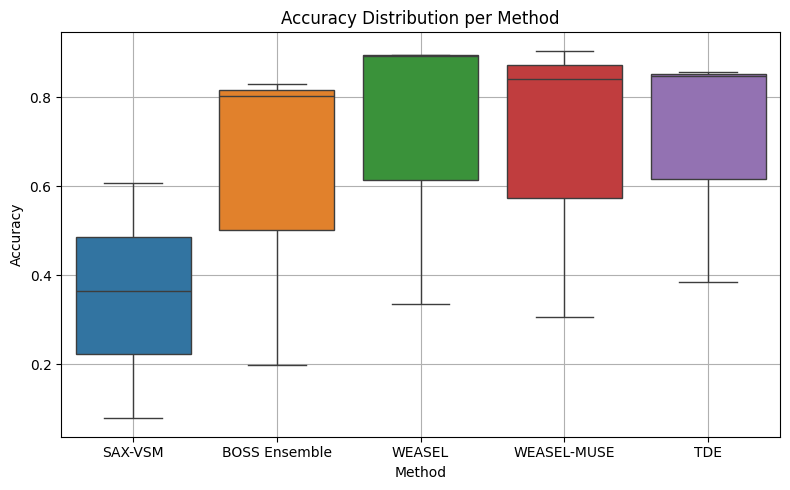

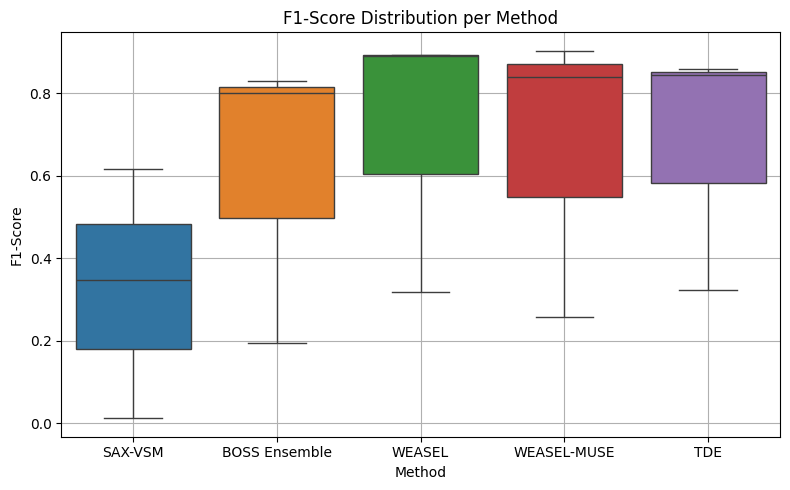

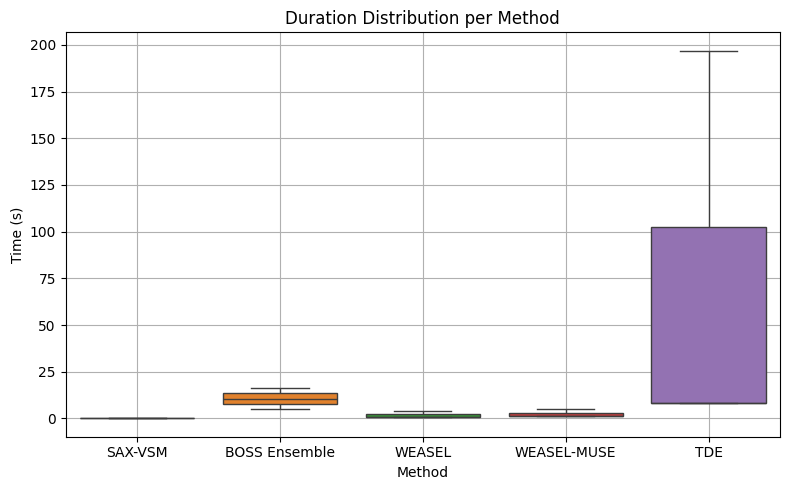

In [15]:
datasets = list(accuracy_dict.keys())
methods = list(next(iter(accuracy_dict.values())).keys())

def prepare_long_format(metric_dict, metric_name):
    records = []
    for ds in datasets:
        for method in methods:
            val = metric_dict[ds][method]
            if isinstance(val, (int, float)):
                records.append({
                    "Dataset": ds,
                    "Method": method,
                    "Metric": float(val),
                    "Type": metric_name
                })
    return pd.DataFrame(records)

df_accuracy = prepare_long_format(accuracy_dict, "Accuracy")
df_f1 = prepare_long_format(f1_score_dict, "F1-Score")
df_duration = prepare_long_format(duration_dict, "Duration (s)")

df_all = pd.concat([df_accuracy, df_f1, df_duration], ignore_index=True)

def plot_boxplot(df, title, ylabel):
    plt.figure(figsize=(8, 5))
    sns.boxplot(data=df, x="Method", y="Metric", hue="Method")
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel("Method")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_boxplot(df_accuracy, "Accuracy Distribution per Method", "Accuracy")
plot_boxplot(df_f1, "F1-Score Distribution per Method", "F1-Score")
plot_boxplot(df_duration, "Duration Distribution per Method", "Time (s)")